In [13]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 1. Caricamento del dataset
df = pd.read_csv('imdb_top_1000.csv')

# 2. Pulizia iniziale: Rimuoviamo le colonne inutili per il ML o "del futuro" considerata l'idea
# Rimuoviamo anche l'Overview (ovvero la trama)
colonne_da_rimuovere = ['Poster_Link', 'Overview', 'Gross', 'No_of_Votes']
df = df.drop(columns=colonne_da_rimuovere, errors='ignore')

In [15]:
print("--- FASE 1: DATA CLEANING (Gestione Missing Values) ---")

# Imputazione dei valori mancanti per la variabile categorica 'Certificate' utilizzando la moda
moda_certificate = df['Certificate'].mode()[0]
df['Certificate'] = df['Certificate'].fillna(moda_certificate)

# Imputazione dei valori mancanti per la variabile numerica 'Meta_score' utilizzando la mediana (robusta agli outlier)
mediana_meta = df['Meta_score'].median()
df['Meta_score'] = df['Meta_score'].fillna(mediana_meta)

print("Controllo valori nulli dopo l'imputazione:")
print(df.isnull().sum())


--- FASE 1: DATA CLEANING (Gestione Missing Values) ---
Controllo valori nulli dopo l'imputazione:
Series_Title     0
Released_Year    0
Certificate      0
Runtime          0
Genre            0
IMDB_Rating      0
Meta_score       0
Director         0
Star1            0
Star2            0
Star3            0
Star4            0
dtype: int64


In [16]:

print("\n--- FASE 2: CREAZIONE VARIABILE TARGET ---")

# Normalizzazione delle metriche di valutazione su una scala comune [0, 1]
df['IMDB_norm'] = df['IMDB_Rating'] / 10.0
df['Meta_norm'] = df['Meta_score'] / 100.0

# Calcolo della differenza numerica tra il gradimento del pubblico e quello della critica
df['Diff_Voto'] = df['IMDB_norm'] - df['Meta_norm']

# Funzione di discretizzazione per generare le 3 classi di output del task di classificazione
def classifica_film(differenza):
    if differenza > 0.05:
        return "2 - Pop (Pubblico > Critica)"
    elif differenza < -0.05:
        return "0 - Snob (Critica > Pubblico)"
    else:
        return "1 - Allineati"

# Applicazione della funzione e rimozione delle feature temporanee di appoggio
df['Target_PreScreening'] = df['Diff_Voto'].apply(classifica_film)
df = df.drop(columns=['IMDB_norm', 'Meta_norm', 'Diff_Voto'])

print("\n--- DISTRIBUZIONE DELLA VARIABILE TARGET ---")
print(df['Target_PreScreening'].value_counts())


--- FASE 2: CREAZIONE VARIABILE TARGET ---

--- DISTRIBUZIONE DELLA VARIABILE TARGET ---
Target_PreScreening
1 - Allineati                    418
2 - Pop (Pubblico > Critica)     312
0 - Snob (Critica > Pubblico)    270
Name: count, dtype: int64


In [17]:
# --- FASE 3: FEATURE ENGINEERING ---

# 1. Assicuriamoci che la durata sia un numero intero (convertendo prima in stringa per evitare errori se c'è la parola 'min')
df['Runtime'] = df['Runtime'].astype(str).str.replace(' min', '').astype(int)

# 2. One-Hot Encoding sui Generi (trasforma "Action, Drama" in colonne binarie 0/1)
generi_encoded = df['Genre'].str.get_dummies(sep=', ')
df = pd.concat([df, generi_encoded], axis=1)

# 3. Pulizia colonne di testo per il ML (evitiamo la curse of dimensionality)
colonne_testuali = ['Series_Title', 'Genre', 'Director', 'Star1', 'Star2', 'Star3', 'Star4', 'Certificate', 'Released_Year']
df = df.drop(columns=colonne_testuali, errors='ignore')

print("Fase 3 completata! Il dataset è pronto per il Machine Learning.")
print("Dimensioni attuali:", df.shape)

Fase 3 completata! Il dataset è pronto per il Machine Learning.
Dimensioni attuali: (1000, 25)


Qui dobbiamo separare le caratteristiche del film (X matrice) dal risultato che vogliamo indovinare (y vettore)

In [19]:
#X contiene tutto tranne la colonna target (variabili predittive)
X= df.drop(columns=['Target_PreScreening'])

#y è solo la colonna target, la soluzione
y= df['Target_PreScreening']

Per evitare il fenomeno dell'Overfitting (imparando tutto a memoria) usiamo l'80% dei film per la fase di training e nascondiamo il 20% per il testing. Usiamo il random state per garantire la riproducibilità dell'esperimento

In [20]:
#strumento per tagliare
from sklearn.model_selection import train_test_split

#dividiamo in 4 blocchi
#test_size=0.2 indica quel 20% riservato al testing
#random_state=42 serve per rendere sempre identico il taglio
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

Usiamo l'algoritmo Random Forest 

In [21]:
#importiamo il modello
from sklearn.ensemble import RandomForestClassifier

#creiamo il modello con 100 alberi
modello_rf= RandomForestClassifier(n_estimators=100, random_state=42)

Usiamo la funzione fit() che addestra e adatta il nostro modello. Gli stiamo dando il materiale da cui studiare e la soluzione a questi 

In [22]:
#il modello analizza i dati e cerca di capire le regole matematiche dietro la scelta
#di un film pop o flop
modello_rf.fit(X_train, y_train)

print("Addestramento completato!")

Addestramento completato!


Controlliamo l'esito dell'addestramento. Il computer sta usando 
le caratteristiche dei 200 film e per ognungo genera la sua previsione

In [24]:
#chiediamo al modello addestrato di prevedere i dati
y_pred= modello_rf.predict(X_test)

Calcoliamo l'accuratezza generale. La funzione usata mette le due liste
riga per riga, se le risposte coincidono gli assegna un punto.

In [26]:
from sklearn.metrics import accuracy_score

#gli diamo le soluzioni vere
voto= accuracy_score(y_test, y_pred)

print("L'accuratezza del modello è:", voto)

L'accuratezza del modello è: 0.91


L'accuratezza non basta, dobbiamo considerare i casi di Falso Negativo e Falso Positivo, ovvero i casi in cui un film era "snob", non lo abbiamo distribuito ma sarebbe stato un successo "pop" e viceversa.
Dobbiamo usare dunque le Confusion Matrix (quali ha sbagliato e con cosa li ha confusi) e il Classification Report 
(con Precision (quanto ci possiamo fidare), Recall (quanti è riuscito a trovarne il modello di pop nascosti?) e F1-Score (media matematica tra Precision e Recall => se è altp, il modello è sia preciso che sensibile))

In [27]:
#prendiamo i calcolatori dalla libreria
from sklearn.metrics import classification_report, confusion_matrix

#generiamo il report con Precision, Recall e F1-Score
report= classification_report(y_test, y_pred)

print("Report dettagliato (Classification Report):")
print(report)

Report dettagliato (Classification Report):
                               precision    recall  f1-score   support

0 - Snob (Critica > Pubblico)       0.98      0.88      0.93        57
                1 - Allineati       0.84      0.96      0.90        84
 2 - Pop (Pubblico > Critica)       0.96      0.86      0.91        59

                     accuracy                           0.91       200
                    macro avg       0.93      0.90      0.91       200
                 weighted avg       0.92      0.91      0.91       200



Creiamo la tabella degli errori.
Veri Snob= 57. 50 giusti e 7 scambiati per allineati e 0 per falso Pop
Veri Pop= 59. 51 giusti e 8 scambiati per allineati e 0 per falso Snob

In [28]:
#la tabella per gli incroci degli errori
matrice_conf= confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:")
print(matrice_conf)


Confusion Matrix:
[[50  7  0]
 [ 1 81  2]
 [ 0  8 51]]


Realizziamo i grafici

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

#creiamo una figura larga 8 pollici e alta 6
plt.figure(figsize=(8,6))

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

Chiediamo a Seaborn di disegnare una heatmap con i valori della nostra confusion matrix

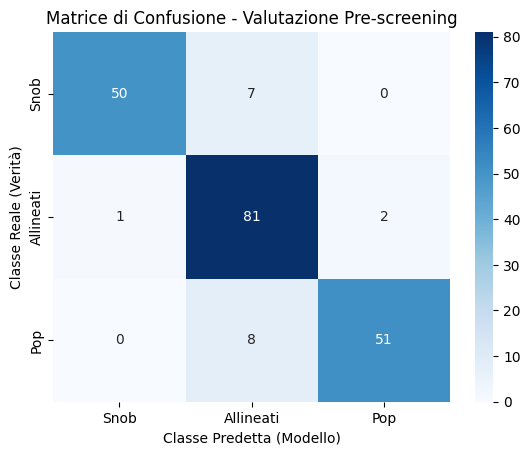

In [36]:
#annot=True: i numeri nei quadrati
#fmt='d', usa i numeri interi (digit)
#cmap='Blues' sfumature blu
sns.heatmap(matrice_conf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Snob', 'Allineati', 'Pop'],
            yticklabels=['Snob', 'Allineati', 'Pop'])

#aggiungiamo i titoli
plt.title('Matrice di Confusione - Valutazione Pre-screening')
plt.ylabel('Classe Reale (Verità)')
plt.xlabel('Classe Predetta (Modello)')

# salviamo l'immagine in formato PDF 
# bbox_inches='tight' serve a non far tagliare i bordi dell'immagine
plt.savefig('matrice_confusione.pdf', bbox_inches='tight')

# Mostriamo il grafico a schermo qui su Jupyter
plt.show()

Grafico della Feature Importance, le colonne più influenti per prendere le decisioni

In [37]:
#creiamo una serie che associa a ciascuna colonna il suo valore di importanza
importanza= pd.Series(modello_rf.feature_importances_, index= X.columns)

#ordiniamo i valori dal più grande al più piccolo e prendiamo i primi 10
top_10_features= importanza.sort_values(ascending=False).head(10)

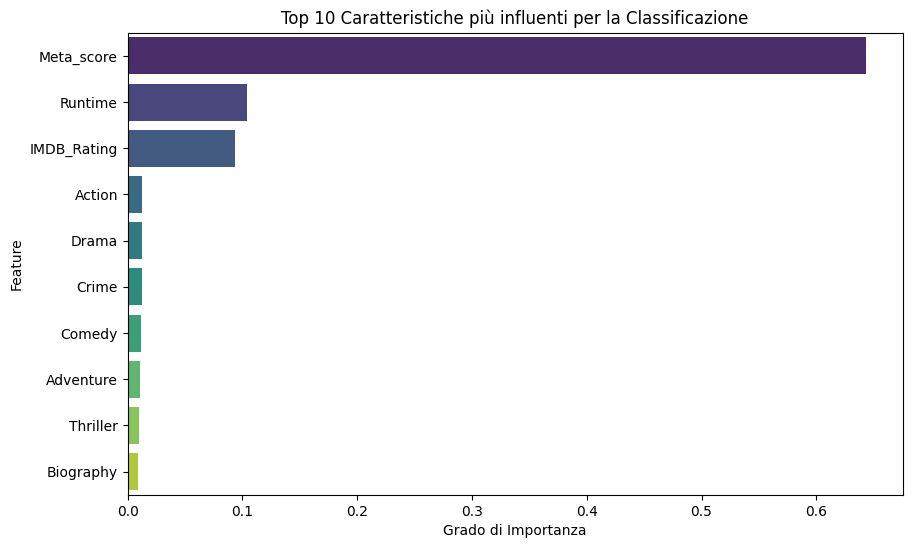

In [39]:
plt.figure(figsize=(10,6))
sns.barplot(x=top_10_features.values, y=top_10_features.index, hue=top_10_features.index, palette='viridis', legend=False)
plt.title('Top 10 Caratteristiche più influenti per la Classificazione')
plt.xlabel('Grado di Importanza')
plt.ylabel('Feature')

# salviamo anche questo per il report
plt.savefig('feature_importance.pdf', bbox_inches='tight')
plt.show()